# Deep Hedging

Deep Hedging goes back to the following paper(https://arxiv.org/abs/1802.03042) by Hans Bühler, Lukas Gonon, Josef Teichmann and Ben Wood. 

The following code is written by Josef Teichmann and Christa Cuchiero

The main idea is to parametrize the hedging strategies (at each time) via neural networks which can depend on input variables chosen by the user, for instance the current price, the past strategy, etc. This then allows to solve a potentially high dimensional hedging problem for many assets whose dynamics are described by an arbitrary given arbitrage free model even in the presence of transaction costs.

Let us exemplify first the idea by the Black Scholes model in one dimension.

## Basic principles of pricing and hedging

We shall first go through basic principles of modeling in mathematical Finance.
To model financial market we shall consider a probability space $ (\Omega,\mathcal{F},P) $ together with a filtration $ (\mathcal{F}_t) $.

We shall denote by $ S^i $ the price of asset $i$ and by $ H^i $ the holdings in asset $i$ (can be any real number here, no market frictions assumed). $ H^i_t $ is fully determined at time $ t- 1 $ with all the information available there.

First we learn to write portfolio values, i.e. $ V_t = \sum_{i=0}^d H^i_tS^i_t $ as P & L processes in case the portfolio is self-financing. Self-financing means that
$$
\sum_{i=0}^d H^i_{t+1}S^i_t = \sum_{i=0}^d H^i_tS^i_t \, ,
$$
which in turn leads to
$$
V_{t+1} - V_t = \sum_{i=0}^d H^i_{t+1} (S^i_{t+1} - S^i_{t}) \, .
$$
This means that the change in value of the portfolio comes from the change in value of the prices and nothing else.

This formula allows for a simplification. If we divide everything by the value of $S^0$, the price of the $0$-th asset, then in the above sum one term vanishes. We denote $ X^i_t = S^i_t/S^0_t $
When discounted, e.g. by $S^0$, this means
$$
\frac{V_t}{S^0_t} - \frac{V_0}{S^0_0} = (H \bullet X)_t = \sum_{s \leq t} \sum_{i=1}^d H^i_{t+1} (X^i_{s+1} - X^i_{s})\, .
$$
Notice that the inner sum only starts at $1$ because $ X^0_t = 1 $.

The right hand side is a P & L process. The argument can be turned around: given a portfolio value which is given by a constant plus a P & L process, then we can of course construct a self-financing portfolio.

We can ask whether arbitrages are possible and under which conditions (for which price) payoffs can be dominated (super-hedged) by self-financing portfolios.

### A model is free of arbitrage if there is no self-financing portfolio which starts at zero and has a positive outcome

This leads us the valuation problem: what is the value of a payoff $f$ at time $T$? We can answer that by constructing appropriate (super-)hedging portfolios. Superhedging just means "dominating".

Let us consider this question in a one period case, i.e. $T=1$. The states of the world are denoted by $\omega$, hence we are interested in the question to find the smallest $ x $ such that for all $ \omega $
$$
f(\omega) \leq x + \sum_{i=1}^d H_0^i (X^i_1(\omega)-X^i_0(\omega)) \, .
$$
This is equivalent to characterize the cone $ C:= \{ (H \bullet X)_1 - g \text{ for all possible strategies } H \text{ and } g \geq 0\} $.

This is a geometric question: the solution is $ C = \{ e \text{ such that } E_Q[e] \leq 0 \text{ for all equivalent martingale measures } $Q$\} $. This yields the beautiful formula
$$
\sup_{Q \in \mathcal{M}} E_Q[f] = \inf \{x \text{ such that there is a strategy } H \text{ with } f \leq x + (H \bullet X)_1 \} \, .
$$
The set $\mathcal{M} $ is the set of equivalent martingale measures. A super-hedging portfolio is a self-financing portfolio (i.e. the value process is the initial value of the portfolio plus the P&L process -- all in discounted terms) dominating a certain payoff.

We have seen in one step bi- and tri-nomial models that pricing and hedging are in a fundamental duality relationship given a certain payoff: the largest arbitrage free price equals the smallest price of a super-hedging portfolio. Superhedging prices can be calculated by backwards induction.

This yields the following pricing formula: if a payoff's contract is liquidly traded at price $ \pi_t(f) $ at intermediate times $ t $, then there exists an equivalent martingale measure for the given market constituted by $X^1,\dots,X^d$ such that
$$
E_Q\big[ \frac{f}{S^0_T} | \mathcal{F}_t \big] = \frac{\pi_t(f)}{S^0_t} .
$$


## Deep Hedging exemplified by means of the Black Scholes model

Let $T$ be a finite time horizon and consider on a filtered probability space $(\Omega, (\mathcal{F}_{0\leq t\leq T}), P)$ a standard Black Sholes model with interest rate $r=0$ and the price of the risky asset $S$ being described by 

\begin{equation*}
dS_t = S_t \mu dt + S_t \sigma dW^P_t, \quad S_0 = S_0
\end{equation*}

under the physical measure $P$. Here $\mu \geq 0$, $\sigma \neq 0$, $S_0 >0$ and $W^P$ is a Brownian motion under $P$.

Under the unique risk neutral probability measure, denoted by $Q$, the dynamics is given by 

\begin{equation*}
 dS_t = S_t \sigma dW^Q_t, \quad S_0 = S_0,
\end{equation*}

where $W^Q$ is a $Q$-Brownian motion



We consider here the problem of hedging a $\mathcal{F}_T$-measureable claim $f(S_T)$. In the case of the Black Scholes model the hedging strategy can be found by the Delta hedge, i.e.,
\begin{equation*}
\Delta(t,s) = \partial_s \mathbb{E}_{Q}[f(S_T) | S_t =s].
\end{equation*}

In more involved models this is no longer possible. In particular in incomplete models not every claim can be hedged and we thus need to optimize a hedging criterion. We here consider a quadratic hedging criterion

Let $\pi$ denote the price of the option, i.e., $\mathbb{E}_Q[f(S_T)]$. Then the goal is to solve the following optimization problem
\begin{equation*}
 \inf_H \mathbb{E} \Big[\Big(f(S_T) - \pi - \int_0^T H_t dS_t\Big)^2\Big],
\end{equation*}
where the stochastic integral represents a value process of a dynamic hedging strategy.

Therefore we choose to specify $H_t$ in a smaller set: for each $t$ as a neural network whose input can be specified. In complete Markovian models, as it is the case of the Black Scholes model, we know from the delta hedging strategy that it makes sense to parameterize $H_t$ as a function of the current price $S_t$. In the current setting we therefore choose that the input of each neural network in the implementation below depends only on the current price, i.e.
\begin{equation*}
 H_t = g_t(S_t)
\end{equation*}
and $g_t$ denotes a neutral network.

We want to find neural network $\{g_t\}$ one for each $t$ so that the following lost function is minimized
\begin{equation*}
 L = \Big(f(S_T(\omega_i)) - \pi - \int_0^T g_t(S_t(\omega_i)) dS_t(\omega_i)\Big)^2.
\end{equation*}
To implement this we need to generate input data which will be our training data set. COnsider the log price $S_t$ under $Q$, i.e.,
\begin{equation*}
d\log(S_t) = -\frac{\sigma^2}{2} dt + \sigma dW_t.
\end{equation*}
We implement this by a time discretization. If we discretize our time interval $[0,T]$ in $N$ time steps of length $T/N$ we can write 
\begin{equation*}
 \log(S_i) = \log(S_{i-1}) - \frac{\sigma^2}{2} \frac{T}{N}+ \sigma \sqrt{\frac{T}{N}} Z_i, \, i=1, \dots, N
\end{equation*}
where $X_i$ are independent $N(0,1)$ distributed random variables. Each increment of $\log(S)$ is a normal random variable with the mean $-\frac{\sigma^2}{2} \frac{T}{N}$ and the standard deviation $\sigma \sqrt{\frac{T}{N}}$.

In the loss function we also need to discretize the stochastic integral
\begin{equation*}
\int_0^T g_t(S_t(\omega)) dS_t(\omega).
\end{equation*}
We do this by choosing $N$ neural networks $g_0, \dots, g_{N-1}$ and disretizing the integral as 
\begin{equation*}
 \sum_{i=0}^{N-1} g_i(S_i(\omega)) (S_{i+1}(\omega) - S_i(\omega)).
\end{equation*}

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from tensorflow.keras.backend import constant
from tensorflow.keras import optimizers

from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/haoxing/.local/lib/python3.6/site-packages/tensorboard/co

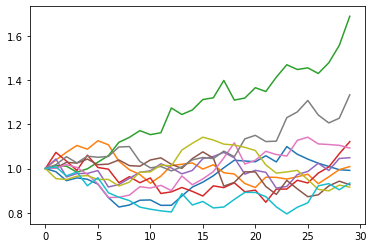

In [2]:
# Trajectories of the Black scholes model

N=30 # time disrectization
S0=1 # initial value of the asset
strike=1 # strike for the call option 
T=1.0 # maturity
sigma=0.2 # volatility in Black Scholes
R=10 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)

for i in range(R):
   plt.plot(S[:,i])
plt.show()

In [3]:
import scipy.stats as scipy
from scipy.stats import norm

#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))

Price of a Call option in the Black scholes model with initial price 1 strike 1 maturity 1.0 and volatility 0.2 is equal to 0.07965567455405798


In [4]:
#Definition of neural networks for hedging strategies

m = 1 # dimension of price
d = 2 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N): # a neural network for each time step
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [5]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))

inputs = [price]+[hedge]


for j in range(N):
    strategy = price
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # hedging strategy at j , i.e. the neural network g_j
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike) - priceBS )(price) 
outputs = Subtract()([payoff,hedge]) # payoff minus price minus hedge 

inputs = inputs
outputs= outputs

model_hedge = Model(inputs=inputs, outputs=outputs)

In [6]:
model_hedge.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
add (Add)                       (None, 1)            0           lambda[0][0]                     
                                                                 input_3[0][0]                

In [7]:
Ktrain = 5*10**4
initialprice = S0

# xtrain = [the price S0] + [the initial hedging being 0] + [the increments of the log price process] 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

# ytrain = output of hedging error initiated at 0
ytrain=np.zeros((Ktrain,1))

In [8]:
model_hedge.compile(optimizer='adam',loss='mean_squared_error')

1563/1563 [==============================] - 9s 4ms/step - loss: 0.0604


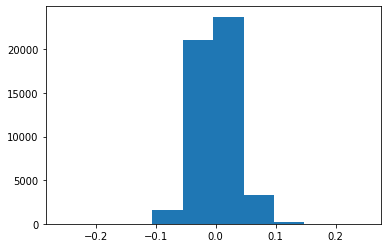

-3.1234747e-05
1563/1563 [==============================] - 7s 4ms/step - loss: 7.7023e-04


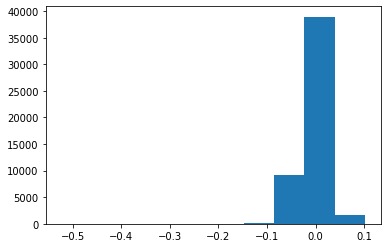

-7.834959e-05
1563/1563 [==============================] - 5s 3ms/step - loss: 6.5378e-04


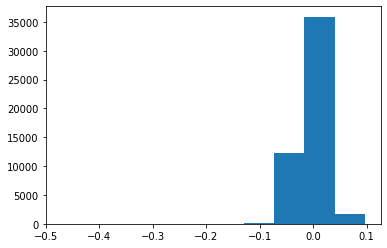

-7.4156065e-05
1563/1563 [==============================] - 5s 4ms/step - loss: 6.4643e-04


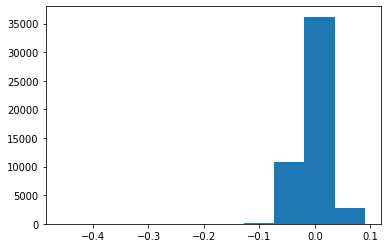

-4.1491898e-05
1563/1563 [==============================] - 5s 3ms/step - loss: 6.3470e-04


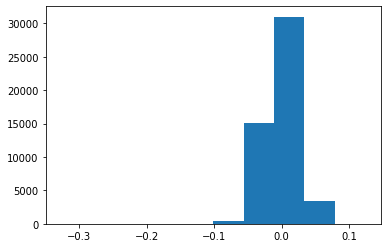

-6.356004e-05
1563/1563 [==============================] - 5s 4ms/step - loss: 6.2166e-04


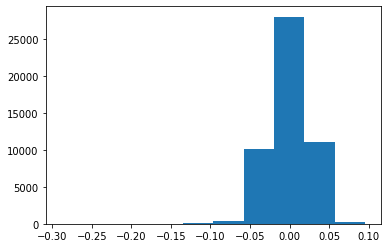

-4.3698205e-05
1563/1563 [==============================] - 7s 4ms/step - loss: 6.0882e-04


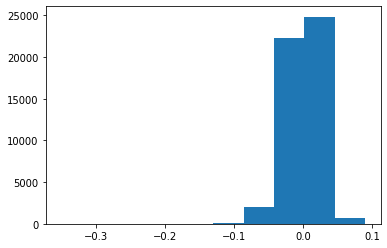

-5.5146542e-05
1563/1563 [==============================] - 6s 4ms/step - loss: 5.9799e-04


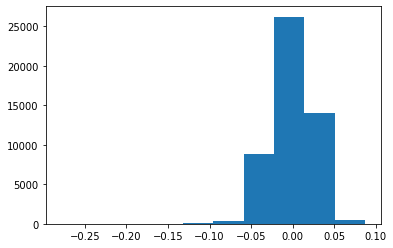

-4.1381827e-05
1563/1563 [==============================] - 6s 4ms/step - loss: 5.8816e-04


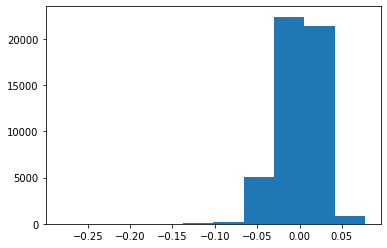

-3.903582e-06
1563/1563 [==============================] - 6s 4ms/step - loss: 5.8015e-04


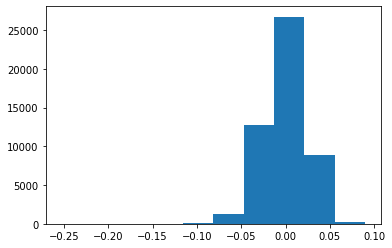

-3.466126e-05


In [9]:
import matplotlib.pyplot as plt

trajectory = []

for i in range(10):
    model_hedge.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)
    weights = model_hedge.get_weights()
    trajectory = trajectory + weights
    plt.hist(model_hedge.predict(xtrain))
    plt.show()
    print(np.mean(model_hedge.predict(xtrain)))

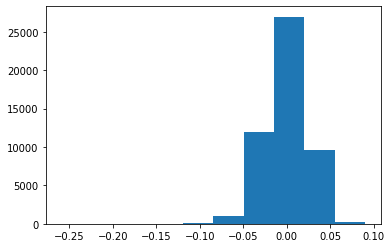

0.024092779
1.4567789e-05


In [10]:
Ltest = 10**4

# change initialprice below to 2 and see how the prediction works
xtest=([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),(sigma)*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])
plt.hist(model_hedge.predict(xtest))
plt.show()
print(np.std(model_hedge.predict(xtest)))
print(np.mean(model_hedge.predict(xtest)))

In [11]:
weights = model_hedge.get_weights()
print(weights)

[array([[-0.12650825,  0.9843931 ,  1.0828255 ,  1.2774297 , -1.1556379 ,
        -0.87071854, -1.0964446 , -0.02674236,  0.14890887, -0.05303164,
         1.0395107 , -0.16002432, -0.16552475,  1.2052135 , -0.44992307,
         1.2700301 , -0.5613436 , -1.3522727 ,  0.05342757, -1.5589877 ,
         0.85820884,  0.93862945,  0.08267879, -0.31284294, -0.0448973 ,
         1.3470476 , -1.4285141 , -0.45438117,  1.4012798 , -0.6095628 ,
        -0.8484989 , -0.1283512 ]], dtype=float32), array([-0.06436668,  0.04716945, -0.01016937, -0.0540367 , -0.01966916,
        0.04323364, -0.07993352, -0.02894448, -0.06756476,  0.03699654,
        0.09468886,  0.15963972,  0.05486015,  0.05178432, -0.06690585,
        0.05156216,  0.02481773,  0.08664549, -0.05311357, -0.00455629,
        0.04160922, -0.0502146 ,  0.03719039,  0.01340861, -0.01743794,
       -0.05651551,  0.07016035, -0.09763326,  0.07546625, -0.00507218,
        0.04348277,  0.0797174 ], dtype=float32), array([[-3.5133278e-01],
  

In [12]:
#This works when the number of layers equals d=2

def deltastrategy(s,j):
    length=s.shape[0]
    g=np.zeros(length)
    for p in range(length):
        ghelper=np.tanh(s[p]*(weights[j*2*d])+weights[j*2*d+1])
        #for k in range(1,d-1): #this line has to be checked in the case for d >2
        #    ghelper=np.tanh(np.matmul(weights[2*k+j*2*d], ghelper[0])+weights[2*k+j*2*d+1])
        g[p]=np.sum(np.squeeze(weights[2*(d-1)+j*2*d])*np.squeeze(ghelper))
        g[p]=g[p]+weights[2*d-1+j*2*d]   
    return g

In [13]:
s=np.linspace(0.5,1.5,10) # range for the asset price to compute the hedging strategy
k=21 # choose k between 1 and N-1 

learneddelta=deltastrategy(s,k)
truedelta=scipy.norm.cdf((np.log(s/strike)+0.5*(T-k*T/N)*sigma**2)/(np.sqrt(T-k*T/N)*sigma))

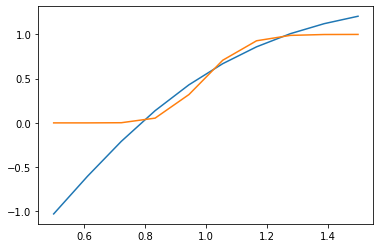

In [14]:
# This plots the true versus the learned Hedging strategy
plt.plot(s,learneddelta,s,truedelta)
plt.show()